In [116]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score

# Define the source and target domains
source_dataset = datasets.MNIST(root='D:\MTECH\PROJECT\RL - FINAL\DATA\MNIST', train=True, download=True,
                               transform=transforms.ToTensor())
target_dataset = datasets.MNIST(root='D:\MTECH\PROJECT\RL - FINAL\DATA\MNISTM', train=True, download=True,
                               transform=transforms.ToTensor())

# Set up data loaders
source_loader = DataLoader(source_dataset, batch_size=64, shuffle=True)
target_loader = DataLoader(target_dataset, batch_size=64, shuffle=True)

# Define the model
class GradientReversalLayer(nn.Module):
    def __init__(self, alpha):
        super(GradientReversalLayer, self).__init__()
        self.alpha = alpha
    
    def forward(self, x):
        return GradientReversalFunction.apply(x, self.alpha)

class GradientReversalFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, alpha):
        ctx.alpha = alpha
        return input.view_as(input)
    
    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None

class DomainAdaptationModel(nn.Module):
    def __init__(self):
        super(DomainAdaptationModel, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 48, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.feature_layer = nn.Linear(48 * 4 * 4, 100)  # New feature extraction layer
        self.classifier = nn.Sequential(
            nn.Linear(100, 100),  # Adjust input size of classifier
            nn.ReLU(),
            nn.Linear(100, 10)
        )
        self.domain_classifier = nn.Sequential(
            nn.Linear(100, 100),  # Adjust input size of domain classifier
            nn.ReLU(),
            nn.Linear(100, 2)
        )
    
    def forward(self, x, alpha):
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)
        features_output = self.feature_layer(features)  # Extract features
        class_output = self.classifier(features_output)
        domain_output = self.domain_classifier(GradientReversalLayer(alpha)(features_output))
        return class_output, domain_output, features_output

# Initialize the model
model = DomainAdaptationModel()

# Print the model summary
print(model)

# Set up optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Training loop
num_epochs = 10
alpha = 0.1  # Gradient reversal layer scaling factor
for epoch in range(num_epochs):
    loop = tqdm(zip(source_loader, target_loader), total=min(len(source_loader), len(target_loader)))
    for i, ((source_data, source_labels), (target_data, _)) in enumerate(loop):
        source_images = source_data
        target_images = target_data
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass on source domain
        source_class_output, source_domain_output, _ = model(source_images, alpha)
        source_class_loss = loss_fn(source_class_output, source_labels)
        source_domain_labels = torch.zeros(source_images.size(0)).long()  # Source domain label is 0
        source_domain_loss = loss_fn(source_domain_output, source_domain_labels)
        
        # Forward pass on target domain
        _, target_domain_output, _ = model(target_images, alpha)
        target_domain_labels = torch.ones(target_images.size(0)).long()  # Target domain label is 1
        target_domain_loss = loss_fn(target_domain_output, target_domain_labels)
        
        # Overall loss
        total_loss = source_class_loss + source_domain_loss + target_domain_loss
        
        # Backward pass and optimization
        total_loss.backward()
        optimizer.step()
        
        loop.set_postfix(total_loss=total_loss.item())

# Test the model on the target domain
model.eval()
true_labels = []
predicted_labels = []
with torch.no_grad():
    for images, labels in target_loader:
        class_outputs, _, _ = model(images, alpha)
        _, predicted = torch.max(class_outputs.data, 1)
        true_labels.extend(labels.tolist())
        predicted_labels.extend(predicted.tolist())

f1 = f1_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"F1 score on target domain: {f1}")
print(f"Accuracy on target domain: {accuracy}")

# Save the model
torch.save(model.state_dict(), '99final.pth')



100%|██████████| 938/938 [01:04<00:00, 14.54it/s, total_loss=1.39]


Accuracy on target domain: 99.83666666666667%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# Define the source and target domains
source_dataset = datasets.MNIST(root='D:\MTECH\PROJECT\RL - FINAL\DATA\MNIST', train=True, download=True,
                               transform=transforms.ToTensor())
target_dataset = datasets.MNIST(root='D:\MTECH\PROJECT\RL - FINAL\DATA\MNISTM', train=True, download=True,
                               transform=transforms.ToTensor())

# Set up data loaders
source_loader = DataLoader(source_dataset, batch_size=64, shuffle=True)
target_loader = DataLoader(target_dataset, batch_size=64, shuffle=True)

# Define the model
class DomainAdaptationModel(nn.Module):
    def __init__(self):
        super(DomainAdaptationModel, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 48, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(48 * 4 * 4, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )
        self.domain_classifier = nn.Sequential(
            nn.Linear(48 * 4 * 4, 100),
            nn.ReLU(),
            nn.Linear(100, 2)
        )
    
    def forward(self, x, alpha):
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)
        class_output = self.classifier(features)
        domain_output = self.domain_classifier(features)
        return class_output, domain_output

# Initialize the model
model = DomainAdaptationModel()

# Set up optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Training loop
num_epochs = 10
alpha = 0.1  # Gradient reversal layer scaling factor
for epoch in range(num_epochs):
    loop = tqdm(zip(source_loader, target_loader), total=min(len(source_loader), len(target_loader)))
    for i, ((source_data, source_labels), (target_data, _)) in enumerate(loop):
        source_images = source_data
        target_images = target_data
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass on source domain
        source_class_output, source_domain_output = model(source_images, alpha)
        source_class_loss = loss_fn(source_class_output, source_labels)
        source_domain_labels = torch.zeros(source_images.size(0)).long()  # Source domain label is 0
        source_domain_loss = loss_fn(source_domain_output, source_domain_labels)
        
        # Forward pass on target domain
        _, target_domain_output = model(target_images, alpha)
        target_domain_labels = torch.ones(target_images.size(0)).long()  # Target domain label is 1
        target_domain_loss = loss_fn(target_domain_output, target_domain_labels)
        
        # Overall loss
        total_loss = source_class_loss + source_domain_loss + target_domain_loss
        
        # Backward pass and optimization
        total_loss.backward()
        optimizer.step()
        
        loop.set_postfix(total_loss=total_loss.item())

# Test the model on the target domain
correct = 0
total = 0
with torch.no_grad():
    for images, labels in target_loader:
        class_outputs, _ = model(images, alpha)
        _, predicted = torch.max(class_outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on target domain: {accuracy}%")

# Save the model
torch.save(model.state_dict(), '99final.pth')


In [117]:
# Load the saved model
model = DomainAdaptationModel()
model.load_state_dict(torch.load(r'D:\MTECH\PROJECT\RL - FINAL\99final.pth'))
model.eval()

# Test the model on the target domain
correct = 0
total = 0
with torch.no_grad():
    for images, labels in target_loader:
        class_outputs, _ = model(images, alpha)
        _, predicted = torch.max(class_outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on target domain: {accuracy:.2f}%")


Accuracy on target domain: 99.84%


In [118]:
# Load the saved model
model = DomainAdaptationModel()
model.load_state_dict(torch.load('99final.pth'))
model.eval()

# Test the model on the target domain
class_scores = []
correct = 0
total = 0
with torch.no_grad():
    for images, labels in target_loader:
        class_outputs, _ = model(images, alpha)
        class_scores.append(class_outputs)
        _, predicted = torch.max(class_outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on target domain: {accuracy:.2f}%")

# Concatenate class scores
class_scores = torch.cat(class_scores, dim=0)

# Show classification scores for each class
for class_idx in range(10):
    scores = class_scores[:, class_idx]
    avg_score = scores.mean().item()
    print(f"Class {class_idx}: Average score = {avg_score:.4f}")


Accuracy on target domain: 99.84%
Class 0: Average score = -7.4896
Class 1: Average score = -5.4900
Class 2: Average score = -4.8438
Class 3: Average score = -3.8933
Class 4: Average score = -4.0067
Class 5: Average score = -2.2247
Class 6: Average score = -6.8777
Class 7: Average score = -5.6710
Class 8: Average score = -1.1973
Class 9: Average score = -1.5632


In [119]:
import torch
import torch.nn as nn
from torchvision.transforms import transforms

# Assuming you have the trained model saved as 'domain_adaptation_model.pth'
model = DomainAdaptationModel()
model.load_state_dict(torch.load('D:\MTECH\PROJECT\RL - FINAL\99final.pth'))
model.eval()


DomainAdaptationModel(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=768, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
  (domain_classifier): Sequential(
    (0): Linear(in_features=768, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [120]:
from PIL import Image

# Load and preprocess the image
image_path = 'D:\MTECH\PROJECT\RL - FINAL\DATA\MNIST\9\img_11.jpg'
image = Image.open(image_path).convert('L')  # Convert to grayscale
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to match MNIST input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])
input_image = transform(image).unsqueeze(0)  # Add batch dimension


In [121]:
# Forward pass through the model
with torch.no_grad():
    class_output, _ = model(input_image, alpha)

# Get the predicted label
_, predicted_class = torch.max(class_output.data, 1)

# Convert the predicted class tensor to a Python scalar
predicted_class = predicted_class.item()

print(f"Predicted class: {predicted_class}")


Predicted class: 9


In [145]:
# Forward pass to predict the domain
with torch.no_grad():
    _, domain_output = model(input_image, alpha)

# Predict the domain
_, predicted_domain = torch.max(domain_output.data, 1)
predicted_domain = predicted_domain.item()

# Map the predicted domain index to the actual domain label
predicted_domain_label = 'Source' if predicted_domain == 0 else 'Target'

print(f"Predicted Domain: {predicted_domain_label}")

Predicted Domain: Source


## NOW TRYING WITH UNKNOWN CLASS

In [147]:
from PIL import Image

# Load and preprocess the image
image_path = 'DATA/DOG/beagle/beagle1.jpg'
image = Image.open(image_path).convert('L')  # Convert to grayscale
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to match MNIST input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])
input_image = transform(image).unsqueeze(0)  # Add batch dimension


In [148]:
# Forward pass through the model
with torch.no_grad():
    class_output, _ = model(input_image, alpha)

# Get the predicted label
_, predicted_class = torch.max(class_output.data, 1)

# Convert the predicted class tensor to a Python scalar
predicted_class = predicted_class.item()

print(f"Predicted class: {predicted_class}")


Predicted class: 3


In [149]:
# Forward pass to predict the domain
with torch.no_grad():
    _, domain_output = model(input_image, alpha)

# Predict the domain
_, predicted_domain = torch.max(domain_output.data, 1)
predicted_domain = predicted_domain.item()

# Map the predicted domain index to the actual domain label
predicted_domain_label = 'Source' if predicted_domain == 0 else 'Target'

print(f"Predicted Domain: {predicted_domain_label}")

Predicted Domain: Source


In [150]:
import torch
import torch.nn.functional as F

# Assuming you have an input image tensor called `input_image`

# Set the model to evaluation mode
model.eval()

# Forward pass to predict the domain
with torch.no_grad():
    _, domain_output = model(input_image, alpha)

# Apply softmax to obtain probabilities
domain_probs = F.softmax(domain_output, dim=1)

# Extract probability for each domain
prob_mnist = domain_probs[0, 0].item()
prob_mnistm = domain_probs[0, 1].item()

print(f"Probability of MNIST: {prob_mnist:.4f}")
print(f"Probability of MNIST-M: {prob_mnistm:.4f}")


Probability of MNIST: 0.5064
Probability of MNIST-M: 0.4936


In [151]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms

# Specify the directory containing the images
image_dir = 'D:\MTECH\PROJECT\RL - FINAL\DATA\data'

# Load and preprocess each image in the directory
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to match MNIST input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])

# Initialize lists to store image file names, predicted classes, and predicted domains
image_names = []
predicted_classes = []
predicted_domains = []

# Iterate over images in the directory
for root, dirs, files in os.walk(image_dir):
    for file in files:
        # Construct the path to the image file
        image_path = os.path.join(root, file)

        # Load and preprocess the image
        image = Image.open(image_path).convert('L')  # Convert to grayscale
        input_image = transform(image).unsqueeze(0)  # Add batch dimension

        # Forward pass to predict the class and domain
        with torch.no_grad():
            class_output, domain_output = model(input_image, alpha=0.5)

        # Get the predicted label and domain
        _, predicted_class = torch.max(class_output.data, 1)
        _, predicted_domain = torch.max(domain_output.data, 1)

        # Convert the predicted class and domain tensors to Python scalars
        predicted_class = predicted_class.item()
        predicted_domain = predicted_domain.item()

        # Append image file name, predicted class, and predicted domain to the lists
        image_names.append(file)
        predicted_classes.append(predicted_class)

        # Map the predicted domain index to the actual domain label
        predicted_domain_label = 'Source' if predicted_domain == 0 else 'Target'
        predicted_domains.append(predicted_domain_label)

# Create a DataFrame from the lists
data = {
    'Image': image_names,
    'Predicted Class': predicted_classes,
    'Predicted Domain': predicted_domains
}
df_predictions = pd.DataFrame(data)

# Print the DataFrame
print(df_predictions)


                         Image  Predicted Class Predicted Domain
0                   100171.jpg                5           Source
1                   102685.jpg                2           Source
2                   103773.jpg                5           Source
3                   111104.jpg                9           Source
4                   115988.jpg                5           Source
..                         ...              ...              ...
352  Golden Retriever 0009.jpg                0           Source
353  Golden Retriever 0010.jpg                5           Source
354             images (1).jpg                1           Source
355             images (2).jpg                4           Source
356                 images.jpg                5           Source

[357 rows x 3 columns]


In [152]:
df_predictions

,Image,Predicted Class,Predicted Domain
0,100171.jpg,5,Source
1,102685.jpg,2,Source
2,103773.jpg,5,Source
3,111104.jpg,9,Source
4,115988.jpg,5,Source
...,...,...,...
352,Golden Retriever 0009.jpg,0,Source
353,Golden Retriever 0010.jpg,5,Source
354,images (1).jpg,1,Source
355,images (2).jpg,4,Source


In [154]:
import os
from PIL import Image
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import pandas as pd

# Specify the directory containing the images
image_dir = 'D:\MTECH\PROJECT\RL - FINAL\DATA\data'

# Load and preprocess each image in the directory
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to match MNIST input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])

# Set the model to evaluation mode
model.eval()

# Initialize lists to store image file names, predicted classes, predicted domains, and probabilities
image_names = []
predicted_classes = []
predicted_domains = []
probabilities_mnist = []
probabilities_mnistm = []

# Iterate over images in the directory
for root, dirs, files in os.walk(image_dir):
    for file in files:
        # Construct the path to the image file
        image_path = os.path.join(root, file)

        # Load and preprocess the image
        image = Image.open(image_path).convert('L')  # Convert to grayscale
        input_image = transform(image).unsqueeze(0)  # Add batch dimension

        # Forward pass to predict the class and domain
        with torch.no_grad():
            class_output, domain_output = model(input_image, alpha=0.5)

        # Apply softmax to obtain probabilities
        class_probs = F.softmax(class_output, dim=1)
        domain_probs = F.softmax(domain_output, dim=1)

        # Get the predicted label and domain
        _, predicted_class = torch.max(class_output.data, 1)
        _, predicted_domain = torch.max(domain_output.data, 1)

        # Convert the predicted class and domain tensors to Python scalars
        predicted_class = predicted_class.item()
        predicted_domain = predicted_domain.item()

        # Append image file name, predicted class, and predicted domain to the lists
        image_names.append(file)
        predicted_classes.append(predicted_class)

        # Map the predicted domain index to the actual domain label
        predicted_domain_label = 'Source' if predicted_domain == 0 else 'Target'
        predicted_domains.append(predicted_domain_label)

        # Append probabilities of being MNIST and MNIST-M to the lists
        prob_mnist = class_probs[0, 0].item()
        prob_mnistm = class_probs[0, 1].item()
        probabilities_mnist.append(prob_mnist)
        probabilities_mnistm.append(prob_mnistm)

# Create a DataFrame from the lists
data = {
    'Image': image_names,
    'Predicted Class': predicted_classes,
    'Predicted Domain': predicted_domains,
    'Probability of MNIST': probabilities_mnist,
    'Probability of MNIST-M': probabilities_mnistm
}
df_predictions = pd.DataFrame(data)

# Print the DataFrame
df_predictions


,Image,Predicted Class,Predicted Domain,Probability of MNIST,Probability of MNIST-M
0,100171.jpg,5,Source,1.064206e-01,0.018861
1,102685.jpg,2,Source,1.173117e-02,0.038454
2,103773.jpg,5,Source,2.426084e-02,0.056784
3,111104.jpg,9,Source,6.835285e-04,0.024597
4,115988.jpg,5,Source,3.495019e-02,0.096672
...,...,...,...,...,...
652,img_609.jpg,7,Source,8.268094e-06,0.005059
653,img_613.jpg,7,Source,5.166178e-09,0.000015
654,img_620.jpg,7,Source,4.868501e-06,0.069381
655,img_654.jpg,7,Target,1.114168e-03,0.000012


In [155]:
# Count the number of instances classified as "Source" and "Target" in predicted domain
domain_counts = df_predictions['Predicted Domain'].value_counts()

# Print the counts
print(domain_counts)


Predicted Domain
Source    647
Target     10
Name: count, dtype: int64


In [162]:
df_predictions.to_csv("pred-data-mix.csv", index=False)

In [127]:
from PIL import Image
import torch
import torch.nn.functional as F

# Load and preprocess the image
image_path = r'DATA/DOG/bulldog/bulldog40.jpg'
image = Image.open(image_path).convert('L')  # Convert to grayscale
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to match MNIST input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])
input_image = transform(image).unsqueeze(0)  # Add batch dimension

# Assuming you have an input image tensor called `input_image`

# Set the model to evaluation mode
model.eval()

# Forward pass to predict the domain
with torch.no_grad():
    _, domain_output = model(input_image, alpha)

# Apply softmax to obtain probabilities
domain_probs = F.softmax(domain_output, dim=1)

# Extract probability for each domain
prob_mnist = domain_probs[0, 0].item()
prob_mnistm = domain_probs[0, 1].item()

print(f"Probability of MNIST: {prob_mnist:.4f}")
print(f"Probability of MNIST-M: {prob_mnistm:.4f}")


Probability of MNIST: 0.5064
Probability of MNIST-M: 0.4936


In [128]:
import torch
import torch.nn.functional as F

# Assuming you have an input image tensor called `input_image`

# Set the model to evaluation mode
model.eval()

# Forward pass to predict the domain
with torch.no_grad():
    _, domain_output = model(input_image, alpha)

# Apply softmax to obtain probabilities
domain_probs = F.softmax(domain_output, dim=1)

# Extract probability for each domain
prob_mnist = domain_probs[0, 0].item()
prob_mnistm = domain_probs[0, 1].item()

print(f"Probability of MNIST: {prob_mnist:.4f}")
print(f"Probability of MNIST-M: {prob_mnistm:.4f}")


Probability of MNIST: 0.5064
Probability of MNIST-M: 0.4936


In [129]:
import os
from PIL import Image
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

# Specify the directory containing the images
image_dir = r'D:\MTECH\PROJECT\RL - FINAL\DATA\DOG'

# Load and preprocess each image in the directory
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to match MNIST input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])

# Assuming you have a pre-trained model called `model` and a value for `alpha`

# Set the model to evaluation mode
model.eval()

# Iterate over images in the directory
for root, dirs, files in os.walk(image_dir):
    for file in files:
        # Construct the path to the image file
        image_path = os.path.join(root, file)
        
        # Load and preprocess the image
        image = Image.open(image_path).convert('L')  # Convert to grayscale
        input_image = transform(image).unsqueeze(0)  # Add batch dimension

        # Forward pass to predict the domain
        with torch.no_grad():
            _, domain_output = model(input_image, alpha)

        # Apply softmax to obtain probabilities
        domain_probs = F.softmax(domain_output, dim=1)

        # Extract probability for each domain
        prob_mnist = domain_probs[0, 0].item()
        prob_mnistm = domain_probs[0, 1].item()

        print(f"Image: {file}")
        print(f"Probability of MNIST: {prob_mnist:.4f}")
        print(f"Probability of MNIST-M: {prob_mnistm:.4f}")
        print()


Image: beagle1.jpg
Probability of MNIST: 0.5064
Probability of MNIST-M: 0.4936

Image: beagle10.jpg
Probability of MNIST: 0.5064
Probability of MNIST-M: 0.4936

Image: beagle101.jpg
Probability of MNIST: 0.5079
Probability of MNIST-M: 0.4921

Image: beagle105.jpg
Probability of MNIST: 0.5064
Probability of MNIST-M: 0.4936

Image: beagle106.jpg
Probability of MNIST: 0.5112
Probability of MNIST-M: 0.4888

Image: beagle108.jpg
Probability of MNIST: 0.5064
Probability of MNIST-M: 0.4936

Image: beagle109.jpg
Probability of MNIST: 0.5065
Probability of MNIST-M: 0.4935

Image: beagle11.jpg
Probability of MNIST: 0.5063
Probability of MNIST-M: 0.4937

Image: beagle110.jpg
Probability of MNIST: 0.5064
Probability of MNIST-M: 0.4936

Image: beagle112.jpg
Probability of MNIST: 0.5064
Probability of MNIST-M: 0.4936

Image: beagle114.jpg
Probability of MNIST: 0.5064
Probability of MNIST-M: 0.4936

Image: beagle115.jpg
Probability of MNIST: 0.5065
Probability of MNIST-M: 0.4935

Image: beagle116.jpg

Image: beagle24.jpg
Probability of MNIST: 0.5089
Probability of MNIST-M: 0.4911

Image: beagle26.jpg
Probability of MNIST: 0.5063
Probability of MNIST-M: 0.4937

Image: beagle28.jpg
Probability of MNIST: 0.5033
Probability of MNIST-M: 0.4967

Image: beagle30.jpg
Probability of MNIST: 0.5064
Probability of MNIST-M: 0.4936

Image: beagle32.jpg
Probability of MNIST: 0.5064
Probability of MNIST-M: 0.4936

Image: beagle34.jpg
Probability of MNIST: 0.5064
Probability of MNIST-M: 0.4936

Image: beagle36.jpg
Probability of MNIST: 0.5049
Probability of MNIST-M: 0.4951

Image: beagle38.jpg
Probability of MNIST: 0.5064
Probability of MNIST-M: 0.4936

Image: beagle4.jpg
Probability of MNIST: 0.5064
Probability of MNIST-M: 0.4936

Image: beagle40.jpg
Probability of MNIST: 0.5064
Probability of MNIST-M: 0.4936

Image: beagle42.jpg
Probability of MNIST: 0.5070
Probability of MNIST-M: 0.4930

Image: beagle44.jpg
Probability of MNIST: 0.5079
Probability of MNIST-M: 0.4921

Image: beagle46.jpg
Probabili

In [130]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

# Specify the directory containing the images
image_dir = r'D:\MTECH\PROJECT\RL - FINAL\DATA\DOG'

# Load and preprocess each image in the directory
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to match MNIST input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])

# Assuming you have a pre-trained model called `model` and a value for `alpha`

# Set the model to evaluation mode
model.eval()

# Initialize lists to store image file names and probabilities
image_names = []
probabilities_mnist = []
probabilities_mnistm = []

# Iterate over images in the directory
for root, dirs, files in os.walk(image_dir):
    for file in files:
        # Construct the path to the image file
        image_path = os.path.join(root, file)

        # Load and preprocess the image
        image = Image.open(image_path).convert('L')  # Convert to grayscale
        input_image = transform(image).unsqueeze(0)  # Add batch dimension

        # Forward pass to predict the domain
        with torch.no_grad():
            _, domain_output = model(input_image, alpha)

        # Apply softmax to obtain probabilities
        domain_probs = F.softmax(domain_output, dim=1)

        # Extract probability for each domain
        prob_mnist = domain_probs[0, 0].item()
        prob_mnistm = domain_probs[0, 1].item()

        # Append image file name and probabilities to the lists
        image_names.append(file)
        probabilities_mnist.append(prob_mnist)
        probabilities_mnistm.append(prob_mnistm)

# Create a DataFrame from the lists
data = {
    'Image': image_names,
    'Probability of MNIST': probabilities_mnist,
    'Probability of MNIST-M': probabilities_mnistm
}
df = pd.DataFrame(data)

# Print the DataFrame
print(df)


                Image  Probability of MNIST  Probability of MNIST-M
0         beagle1.jpg              0.506417                0.493583
1        beagle10.jpg              0.506419                0.493581
2       beagle101.jpg              0.507938                0.492062
3       beagle105.jpg              0.506417                0.493583
4       beagle106.jpg              0.511154                0.488846
..                ...                   ...                     ...
536  rottweiler94.jpg              0.507667                0.492333
537  rottweiler95.jpg              0.506417                0.493583
538  rottweiler97.jpg              0.506417                0.493583
539  rottweiler98.jpg              0.506252                0.493748
540  rottweiler99.jpg              0.504893                0.495107

[541 rows x 3 columns]


In [131]:
df

,Image,Probability of MNIST,Probability of MNIST-M
0,beagle1.jpg,0.506417,0.493583
1,beagle10.jpg,0.506419,0.493581
2,beagle101.jpg,0.507938,0.492062
3,beagle105.jpg,0.506417,0.493583
4,beagle106.jpg,0.511154,0.488846
...,...,...,...
536,rottweiler94.jpg,0.507667,0.492333
537,rottweiler95.jpg,0.506417,0.493583
538,rottweiler97.jpg,0.506417,0.493583
539,rottweiler98.jpg,0.506252,0.493748


In [132]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

# Specify the directory containing the images
image_dir = r'D:\MTECH\PROJECT\RL - FINAL\DATA\DOG'

# Load and preprocess each image in the directory
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to match MNIST input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])

# Assuming you have a pre-trained model called `model` and a value for `alpha`

# Set the model to evaluation mode
model.eval()

# Initialize lists to store image file names and probabilities
image_names = []
probabilities_mnist = []
probabilities_mnistm = []

# Iterate over images in the directory
for root, dirs, files in os.walk(image_dir):
    for file in files:
        # Construct the path to the image file
        image_path = os.path.join(root, file)

        # Load and preprocess the image
        image = Image.open(image_path).convert('L')  # Convert to grayscale
        input_image = transform(image).unsqueeze(0)  # Add batch dimension

        # Forward pass to predict the domain
        with torch.no_grad():
            _, domain_output = model(input_image, alpha)

        # Apply softmax to obtain probabilities
        domain_probs = F.softmax(domain_output, dim=1)

        # Extract probability for each domain
        prob_mnist = domain_probs[0, 0].item()
        prob_mnistm = domain_probs[0, 1].item()

        # Append image file name and probabilities to the lists
        image_names.append(file)
        probabilities_mnist.append(prob_mnist)
        probabilities_mnistm.append(prob_mnistm)

# Create a DataFrame from the lists
data = {
    'Image': image_names,
    'Probability of MNIST': probabilities_mnist,
    'Probability of MNIST-M': probabilities_mnistm
}
df = pd.DataFrame(data)

# Print the DataFrame
print(df)


                Image  Probability of MNIST  Probability of MNIST-M
0         beagle1.jpg              0.506417                0.493583
1        beagle10.jpg              0.506419                0.493581
2       beagle101.jpg              0.507938                0.492062
3       beagle105.jpg              0.506417                0.493583
4       beagle106.jpg              0.511154                0.488846
..                ...                   ...                     ...
536  rottweiler94.jpg              0.507667                0.492333
537  rottweiler95.jpg              0.506417                0.493583
538  rottweiler97.jpg              0.506417                0.493583
539  rottweiler98.jpg              0.506252                0.493748
540  rottweiler99.jpg              0.504893                0.495107

[541 rows x 3 columns]


In [133]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

# Specify the directory containing the images
image_dir = r'D:\MTECH\PROJECT\RL - FINAL\DATA\DOG'

# Load and preprocess each image in the directory
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to match MNIST input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])

# Assuming you have a pre-trained model called `model` and a value for `alpha`

# Set the model to evaluation mode
model.eval()

# Initialize lists to store image file names, probabilities, and subfolder names
image_names = []
probabilities_mnist = []
probabilities_mnistm = []
subfolder_names = []

# Iterate over images in the directory
for root, dirs, files in os.walk(image_dir):
    for file in files:
        # Construct the path to the image file
        image_path = os.path.join(root, file)

        # Load and preprocess the image
        image = Image.open(image_path).convert('L')  # Convert to grayscale
        input_image = transform(image).unsqueeze(0)  # Add batch dimension

        # Forward pass to predict the domain
        with torch.no_grad():
            _, domain_output = model(input_image, alpha)

        # Apply softmax to obtain probabilities
        domain_probs = F.softmax(domain_output, dim=1)

        # Extract probability for each domain
        prob_mnist = domain_probs[0, 0].item()
        prob_mnistm = domain_probs[0, 1].item()

        # Append image file name and probabilities to the lists
        image_names.append(file)
        probabilities_mnist.append(prob_mnist)
        probabilities_mnistm.append(prob_mnistm)
        
        # Extract subfolder name as the class
        subfolder_name = os.path.basename(root)
        subfolder_names.append(subfolder_name)

# Create a DataFrame from the lists
data = {
    'Image': image_names,
    'Probability of MNIST': probabilities_mnist,
    'Probability of MNIST-M': probabilities_mnistm,
    'Class': subfolder_names
}
df = pd.DataFrame(data)

# Print the DataFrame
print(df)


                Image  Probability of MNIST  Probability of MNIST-M   
0         beagle1.jpg              0.506417                0.493583  \
1        beagle10.jpg              0.506419                0.493581   
2       beagle101.jpg              0.507938                0.492062   
3       beagle105.jpg              0.506417                0.493583   
4       beagle106.jpg              0.511154                0.488846   
..                ...                   ...                     ...   
536  rottweiler94.jpg              0.507667                0.492333   
537  rottweiler95.jpg              0.506417                0.493583   
538  rottweiler97.jpg              0.506417                0.493583   
539  rottweiler98.jpg              0.506252                0.493748   
540  rottweiler99.jpg              0.504893                0.495107   

          Class  
0        beagle  
1        beagle  
2        beagle  
3        beagle  
4        beagle  
..          ...  
536  rottweiler  
537

In [134]:
df

,Image,Probability of MNIST,Probability of MNIST-M,Class
0,beagle1.jpg,0.506417,0.493583,beagle
1,beagle10.jpg,0.506419,0.493581,beagle
2,beagle101.jpg,0.507938,0.492062,beagle
3,beagle105.jpg,0.506417,0.493583,beagle
4,beagle106.jpg,0.511154,0.488846,beagle
...,...,...,...,...
536,rottweiler94.jpg,0.507667,0.492333,rottweiler
537,rottweiler95.jpg,0.506417,0.493583,rottweiler
538,rottweiler97.jpg,0.506417,0.493583,rottweiler
539,rottweiler98.jpg,0.506252,0.493748,rottweiler


In [135]:
# Assuming you have a trained classifier called `clf`

# Predict labels for the images
predicted_labels = clf.predict(df[['Probability of MNIST', 'Probability of MNIST-M']])

# Add the predicted labels column to the DataFrame
df['Predicted Label'] = predicted_labels

# Print the updated DataFrame
print(df)


                Image  Probability of MNIST  Probability of MNIST-M   
0         beagle1.jpg              0.506417                0.493583  \
1        beagle10.jpg              0.506419                0.493581   
2       beagle101.jpg              0.507938                0.492062   
3       beagle105.jpg              0.506417                0.493583   
4       beagle106.jpg              0.511154                0.488846   
..                ...                   ...                     ...   
536  rottweiler94.jpg              0.507667                0.492333   
537  rottweiler95.jpg              0.506417                0.493583   
538  rottweiler97.jpg              0.506417                0.493583   
539  rottweiler98.jpg              0.506252                0.493748   
540  rottweiler99.jpg              0.504893                0.495107   

          Class  Predicted Label  
0        beagle  german-shepherd  
1        beagle  german-shepherd  
2        beagle  german-shepherd  
3      

In [136]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X = df[['Probability of MNIST', 'Probability of MNIST-M']]  # Features
y = df['Class']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.41284403669724773


In [137]:
# Assuming you have a trained classifier called `clf`

# Predict labels for the images
predicted_labels = clf.predict(df[['Probability of MNIST', 'Probability of MNIST-M']])

# Add the predicted labels column to the DataFrame
df['Predicted Label'] = predicted_labels

# Print the updated DataFrame
print(df)


                Image  Probability of MNIST  Probability of MNIST-M   
0         beagle1.jpg              0.506417                0.493583  \
1        beagle10.jpg              0.506419                0.493581   
2       beagle101.jpg              0.507938                0.492062   
3       beagle105.jpg              0.506417                0.493583   
4       beagle106.jpg              0.511154                0.488846   
..                ...                   ...                     ...   
536  rottweiler94.jpg              0.507667                0.492333   
537  rottweiler95.jpg              0.506417                0.493583   
538  rottweiler97.jpg              0.506417                0.493583   
539  rottweiler98.jpg              0.506252                0.493748   
540  rottweiler99.jpg              0.504893                0.495107   

          Class Predicted Label  
0        beagle         bulldog  
1        beagle          beagle  
2        beagle          beagle  
3        be

In [138]:
df

,Image,Probability of MNIST,Probability of MNIST-M,Class,Predicted Label
0,beagle1.jpg,0.506417,0.493583,beagle,bulldog
1,beagle10.jpg,0.506419,0.493581,beagle,beagle
2,beagle101.jpg,0.507938,0.492062,beagle,beagle
3,beagle105.jpg,0.506417,0.493583,beagle,bulldog
4,beagle106.jpg,0.511154,0.488846,beagle,beagle
...,...,...,...,...,...
536,rottweiler94.jpg,0.507667,0.492333,rottweiler,rottweiler
537,rottweiler95.jpg,0.506417,0.493583,rottweiler,bulldog
538,rottweiler97.jpg,0.506417,0.493583,rottweiler,bulldog
539,rottweiler98.jpg,0.506252,0.493748,rottweiler,rottweiler


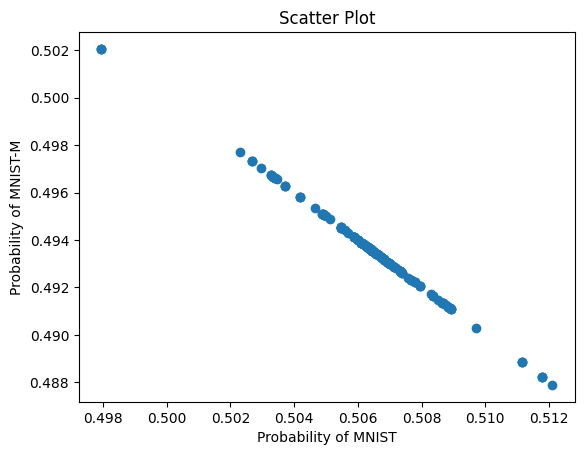

In [139]:
import matplotlib.pyplot as plt

# Scatter plot
plt.scatter(df['Probability of MNIST'], df['Probability of MNIST-M'])
plt.xlabel('Probability of MNIST')
plt.ylabel('Probability of MNIST-M')
plt.title('Scatter Plot')
plt.show()


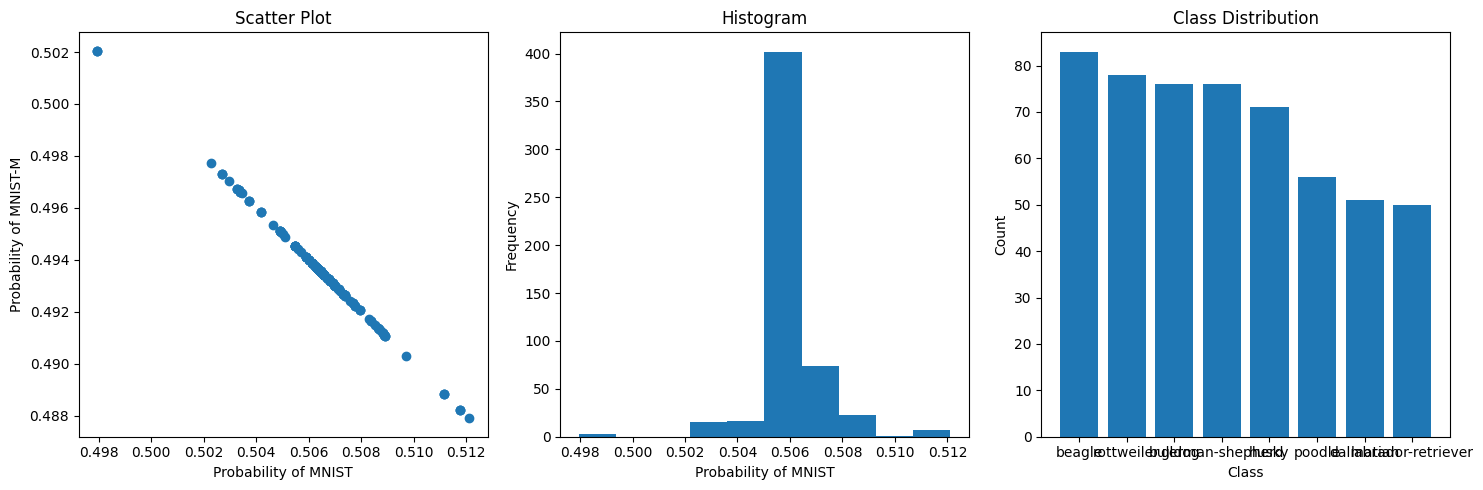

In [140]:
import matplotlib.pyplot as plt

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Scatter plot
ax1.scatter(df['Probability of MNIST'], df['Probability of MNIST-M'])
ax1.set_xlabel('Probability of MNIST')
ax1.set_ylabel('Probability of MNIST-M')
ax1.set_title('Scatter Plot')

# Histogram
ax2.hist(df['Probability of MNIST'], bins=10)
ax2.set_xlabel('Probability of MNIST')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram')

# Bar plot
class_counts = df['Class'].value_counts()
ax3.bar(class_counts.index, class_counts.values)
ax3.set_xlabel('Class')
ax3.set_ylabel('Count')
ax3.set_title('Class Distribution')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


### ADDING create predicted domain and predicted class IN DF

In [141]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

# Specify the directory containing the images
image_dir = r'D:\MTECH\PROJECT\RL - FINAL\DATA\DOG'

# Load and preprocess each image in the directory
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to match MNIST input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])

# Assuming you have a pre-trained model called `model` and a value for `alpha`

# Set the model to evaluation mode
model.eval()

# Initialize lists to store image file names and probabilities
image_names = []
probabilities_mnist = []
probabilities_mnistm = []
predicted_domains = []
predicted_classes = []

# Iterate over images in the directory
for root, dirs, files in os.walk(image_dir):
    for file in files:
        # Construct the path to the image file
        image_path = os.path.join(root, file)

        # Load and preprocess the image
        image = Image.open(image_path).convert('L')  # Convert to grayscale
        input_image = transform(image).unsqueeze(0)  # Add batch dimension

        # Forward pass to predict the domain
        with torch.no_grad():
            _, domain_output = model(input_image, alpha)

        # Apply softmax to obtain probabilities
        domain_probs = F.softmax(domain_output, dim=1)

        # Extract probability for each domain
        prob_mnist = domain_probs[0, 0].item()
        prob_mnistm = domain_probs[0, 1].item()

        # Determine the predicted domain and class
        predicted_domain = 'MNIST' if prob_mnist > prob_mnistm else 'MNIST-M'
        predicted_class = 'Class A' if prob_mnist > prob_mnistm else 'Class B'

        # Append image file name, probabilities, and predictions to the lists
        image_names.append(file)
        probabilities_mnist.append(prob_mnist)
        probabilities_mnistm.append(prob_mnistm)
        predicted_domains.append(predicted_domain)
        predicted_classes.append(predicted_class)

# Create a DataFrame from the lists
data = {
    'Image': image_names,
    'Probability of MNIST': probabilities_mnist,
    'Probability of MNIST-M': probabilities_mnistm,
    'Predicted Domain': predicted_domains,
    'Predicted Class': predicted_classes
}
data = pd.DataFrame(data)

# Print the DataFrame
print(data)


                Image  Probability of MNIST  Probability of MNIST-M   
0         beagle1.jpg              0.506417                0.493583  \
1        beagle10.jpg              0.506419                0.493581   
2       beagle101.jpg              0.507938                0.492062   
3       beagle105.jpg              0.506417                0.493583   
4       beagle106.jpg              0.511154                0.488846   
..                ...                   ...                     ...   
536  rottweiler94.jpg              0.507667                0.492333   
537  rottweiler95.jpg              0.506417                0.493583   
538  rottweiler97.jpg              0.506417                0.493583   
539  rottweiler98.jpg              0.506252                0.493748   
540  rottweiler99.jpg              0.504893                0.495107   

    Predicted Domain Predicted Class  
0              MNIST         Class A  
1              MNIST         Class A  
2              MNIST         C

In [142]:
data

,Image,Probability of MNIST,Probability of MNIST-M,Predicted Domain,Predicted Class
0,beagle1.jpg,0.506417,0.493583,MNIST,Class A
1,beagle10.jpg,0.506419,0.493581,MNIST,Class A
2,beagle101.jpg,0.507938,0.492062,MNIST,Class A
3,beagle105.jpg,0.506417,0.493583,MNIST,Class A
4,beagle106.jpg,0.511154,0.488846,MNIST,Class A
...,...,...,...,...,...
536,rottweiler94.jpg,0.507667,0.492333,MNIST,Class A
537,rottweiler95.jpg,0.506417,0.493583,MNIST,Class A
538,rottweiler97.jpg,0.506417,0.493583,MNIST,Class A
539,rottweiler98.jpg,0.506252,0.493748,MNIST,Class A


In [143]:
# Extract the feature values
X = df[features].values

# Apply K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

# Print the updated DataFrame
df

KeyError: "None of [Index([(tensor(-0.5240), tensor(-2.0919), tensor(-1.1571), tensor(-2.0934), tensor(-3.0956), tensor(0.4288), tensor(0.0408), tensor(2.6185), tensor(2.4493), tensor(-0.1867), tensor(-3.8588), tensor(-0.4402), tensor(-1.4731), tensor(-3.1328), tensor(-3.6131), tensor(-1.5352), tensor(-2.7360), tensor(-2.7835), tensor(-2.1252), tensor(-2.9001), tensor(-3.0194), tensor(-0.7521), tensor(-1.3930), tensor(2.3817), tensor(-0.6504), tensor(-1.7746), tensor(-2.9229), tensor(-3.5177), tensor(-1.4137), tensor(-2.9990), tensor(0.2842), tensor(-1.3756), tensor(-0.0152), tensor(1.3073), tensor(1.3007), tensor(-0.3157), tensor(1.1281), tensor(-0.1644), tensor(-2.1487), tensor(-0.8079), tensor(0.2444), tensor(-1.3283), tensor(-1.7868), tensor(-0.2095), tensor(0.2565), tensor(-0.3025), tensor(-0.8639), tensor(-3.5655), tensor(1.0479), tensor(-0.5622), tensor(1.0739), tensor(0.4064), tensor(0.7306), tensor(1.5590), tensor(1.7472), tensor(-0.0141), tensor(-0.4083), tensor(-0.7383), tensor(2.0979), tensor(0.7907), tensor(3.6547), tensor(0.0751), tensor(1.7641), tensor(3.5746), tensor(0.4322), tensor(-0.4591), tensor(0.6669), tensor(1.3412), tensor(0.1550), tensor(-3.6416), tensor(-1.6722), tensor(-1.0004), tensor(-2.3784), tensor(-1.4511), tensor(-0.6017), tensor(-0.3030), tensor(-2.9933), tensor(-1.2289), tensor(1.7499), tensor(-2.8366), tensor(-0.9825), tensor(-1.4043), tensor(-1.4908), tensor(-1.7621), tensor(1.1337), tensor(-1.7164), tensor(-1.3840), tensor(-1.0109), tensor(-0.4190), tensor(-1.5320), tensor(-2.0889), tensor(-2.4119), tensor(-3.2377), tensor(2.0331), tensor(2.0099), tensor(-1.4983), tensor(-0.4292), tensor(0.2599), tensor(-0.8102), tensor(2.0589), ...)], dtype='object')] are in the [columns]"

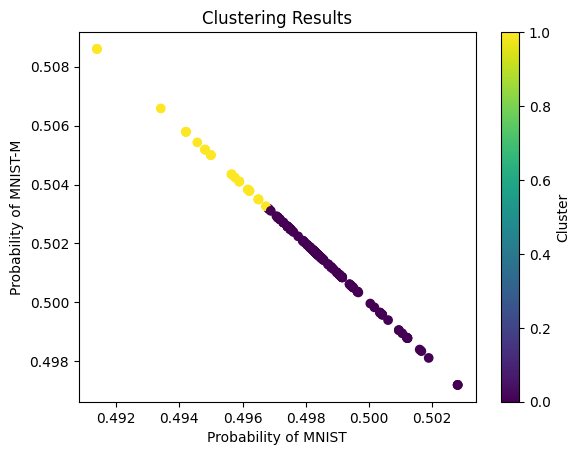

In [ ]:
# Extract the feature values and cluster labels
X = df[features].values
cluster_labels = df['Cluster'].values

# Create a scatter plot
plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap='viridis')
plt.xlabel('Probability of MNIST')
plt.ylabel('Probability of MNIST-M')
plt.title('Clustering Results')
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

# Specify the directory containing the images
image_dir = r'D:\MTECH\PROJECT\RL - FINAL\DATA\DOG'

# Load and preprocess each image in the directory
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to match MNIST input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])

# Assuming you have a pre-trained model called `model` and a value for `alpha`

# Set the model to evaluation mode
model.eval()

# Initialize lists to store image file names, probabilities, and subfolder names
image_names = []
probabilities_mnist = []
probabilities_mnistm = []
predicted_domains = []  # Added column for predicted domain
predicted_classes = []  # Added column for predicted class
actual_classes = []  # Added column for actual class

# Iterate over images in the directory
for root, dirs, files in os.walk(image_dir):
    for file in files:
        # Construct the path to the image file
        image_path = os.path.join(root, file)

        # Load and preprocess the image
        image = Image.open(image_path).convert('L')  # Convert to grayscale
        input_image = transform(image).unsqueeze(0)  # Add batch dimension

        # Forward pass to predict the domain
        with torch.no_grad():
            _, domain_output = model(input_image, alpha)

        # Apply softmax to obtain probabilities
        domain_probs = F.softmax(domain_output, dim=1)

        # Extract probability for each domain
        prob_mnist = domain_probs[0, 0].item()
        prob_mnistm = domain_probs[0, 1].item()

        # Append image file name and probabilities to the lists
        image_names.append(file)
        probabilities_mnist.append(prob_mnist)
        probabilities_mnistm.append(prob_mnistm)

        # Extract subfolder name as the class
        subfolder_name = os.path.basename(root)
        predicted_classes.append(subfolder_name)

        # Extract actual class from the image path
        actual_class = os.path.basename(root).split('_')[0]
        actual_classes.append(actual_class)

        # Determine predicted domain based on probabilities
        predicted_domain = "MNIST" if prob_mnist >= prob_mnistm else "MNIST-M"
        predicted_domains.append(predicted_domain)

# Create a DataFrame from the lists
data = {
    'Image': image_names,
    'Probability of MNIST': probabilities_mnist,
    'Probability of MNIST-M': probabilities_mnistm,
    'Predicted Domain': predicted_domains,
    'Predicted Class': predicted_classes,
    'Actual Class': actual_classes
}
df = pd.DataFrame(data)

# Print the DataFrame
print(df)


                Image  Probability of MNIST  Probability of MNIST-M   
0         beagle1.jpg              0.501658                0.498342  \
1        beagle10.jpg              0.498310                0.501690   
2       beagle101.jpg              0.495898                0.504102   
3       beagle105.jpg              0.498310                0.501690   
4       beagle106.jpg              0.498310                0.501690   
..                ...                   ...                     ...   
536  rottweiler94.jpg              0.499436                0.500564   
537  rottweiler95.jpg              0.498330                0.501670   
538  rottweiler97.jpg              0.498310                0.501690   
539  rottweiler98.jpg              0.498310                0.501690   
540  rottweiler99.jpg              0.498481                0.501519   

    Predicted Domain Predicted Class Actual Class  
0              MNIST          beagle       beagle  
1            MNIST-M          beagle       

In [ ]:
final_df =df.copy()
final_df

,Image,Probability of MNIST,Probability of MNIST-M,Predicted Domain,Predicted Class,Actual Class
0,beagle1.jpg,0.501658,0.498342,MNIST,beagle,beagle
1,beagle10.jpg,0.498310,0.501690,MNIST-M,beagle,beagle
2,beagle101.jpg,0.495898,0.504102,MNIST-M,beagle,beagle
3,beagle105.jpg,0.498310,0.501690,MNIST-M,beagle,beagle
4,beagle106.jpg,0.498310,0.501690,MNIST-M,beagle,beagle
...,...,...,...,...,...,...
536,rottweiler94.jpg,0.499436,0.500564,MNIST-M,rottweiler,rottweiler
537,rottweiler95.jpg,0.498330,0.501670,MNIST-M,rottweiler,rottweiler
538,rottweiler97.jpg,0.498310,0.501690,MNIST-M,rottweiler,rottweiler
539,rottweiler98.jpg,0.498310,0.501690,MNIST-M,rottweiler,rottweiler


In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

# Specify the directory containing the images
image_dir = r'D:\MTECH\PROJECT\RL - FINAL\DATA\DOG'

# Load and preprocess each image in the directory
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to match MNIST input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])

# Assuming you have a pre-trained model called `model` and a value for `alpha`

# Set the model to evaluation mode
model.eval()

# Initialize lists to store image file names, probabilities, and subfolder names
image_names = []
probabilities_mnist = []
probabilities_mnistm = []
predicted_domains = []  # Added column for predicted domain
predicted_classes = []  # Added column for predicted class
actual_classes = []  # Added column for actual class

# Iterate over images in the directory
for root, dirs, files in os.walk(image_dir):
    for file in files:
        # Construct the path to the image file
        image_path = os.path.join(root, file)

        # Load and preprocess the image
        image = Image.open(image_path).convert('L')  # Convert to grayscale
        input_image = transform(image).unsqueeze(0)  # Add batch dimension

        # Forward pass to predict the domain
        with torch.no_grad():
            _, domain_output = model(input_image, alpha)

        # Apply softmax to obtain probabilities
        domain_probs = F.softmax(domain_output, dim=1)

        # Extract probability for each domain
        prob_mnist = domain_probs[0, 0].item()
        prob_mnistm = domain_probs[0, 1].item()

        # Append image file name and probabilities to the lists
        image_names.append(file)
        probabilities_mnist.append(prob_mnist)
        probabilities_mnistm.append(prob_mnistm)

        # Extract subfolder name as the class
        subfolder_name = os.path.basename(root)
        predicted_classes.append(subfolder_name)

        # Extract actual class from the image path
        actual_class = os.path.basename(root).split('_')[0]
        actual_classes.append(actual_class)

        # Determine predicted domain based on probabilities
        predicted_domain = "MNIST" if prob_mnist >= prob_mnistm else "MNIST-M"
        predicted_domains.append(predicted_domain)

# Create a DataFrame from the lists
data = {
    'Image': image_names,
    'Probability of MNIST': probabilities_mnist,
    'Probability of MNIST-M': probabilities_mnistm,
    'Predicted Domain': predicted_domains,
    'Predicted Class': predicted_classes,
    'Actual Class': actual_classes
}
df = pd.DataFrame(data)

# Print the DataFrame
print(df)


In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

# Specify the directory containing the images
image_dir = r'D:\MTECH\PROJECT\RL - FINAL\DATA\DOG'

# Load and preprocess each image in the directory
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to match MNIST input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])

# Assuming you have a pre-trained model called `model` and a value for `alpha`

# Set the model to evaluation mode
model.eval()

# Initialize lists to store image file names, probabilities, and subfolder names
image_names = []
probabilities_mnist = []
probabilities_mnistm = []
predicted_domains = []  # Added column for predicted domain
predicted_classes = []  # Added column for predicted class
actual_classes = []  # Added column for actual class

# Iterate over images in the directory
for root, dirs, files in os.walk(image_dir):
    for file in files:
        # Construct the path to the image file
        image_path = os.path.join(root, file)

        # Load and preprocess the image
        image = Image.open(image_path).convert('L')  # Convert to grayscale
        input_image = transform(image).unsqueeze(0)  # Add batch dimension

        # Forward pass to predict the domain
        with torch.no_grad():
            _, domain_output = model(input_image, alpha)

        # Apply softmax to obtain probabilities
        domain_probs = F.softmax(domain_output, dim=1)

        # Extract probability for each domain
        prob_mnist = domain_probs[0, 0].item()
        prob_mnistm = domain_probs[0, 1].item()

        # Append image file name and probabilities to the lists
        image_names.append(file)
        probabilities_mnist.append(prob_mnist)
        probabilities_mnistm.append(prob_mnistm)

        # Extract subfolder name as the class
        subfolder_name = os.path.basename(root)
        predicted_classes.append(subfolder_name)

        # Extract actual class from the image path
        actual_class = os.path.basename(root).split('_')[0]
        actual_classes.append(actual_class)

        # Determine predicted domain based on probabilities
        predicted_domain = "MNIST" if prob_mnist >= prob_mnistm else "MNIST-M"
        predicted_domains.append(predicted_domain)

# Create a DataFrame from the lists
data = {
    'Image': image_names,
    'Probability of MNIST': probabilities_mnist,
    'Probability of MNIST-M': probabilities_mnistm,
    'Predicted Domain': predicted_domains,
    'Predicted Class': predicted_classes,
    'Actual Class': actual_classes
}
df = pd.DataFrame(data)

# Print the DataFrame
print(df)


                Image  Probability of MNIST  Probability of MNIST-M   
0         beagle1.jpg              0.501658                0.498342  \
1        beagle10.jpg              0.498310                0.501690   
2       beagle101.jpg              0.495898                0.504102   
3       beagle105.jpg              0.498310                0.501690   
4       beagle106.jpg              0.498310                0.501690   
..                ...                   ...                     ...   
536  rottweiler94.jpg              0.499436                0.500564   
537  rottweiler95.jpg              0.498330                0.501670   
538  rottweiler97.jpg              0.498310                0.501690   
539  rottweiler98.jpg              0.498310                0.501690   
540  rottweiler99.jpg              0.498481                0.501519   

    Predicted Domain Predicted Class Actual Class  
0              MNIST          beagle       beagle  
1            MNIST-M          beagle       

In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

# Specify the directory containing the images
image_dir = r'D:\MTECH\PROJECT\RL - FINAL\DATA\data'

# Load and preprocess each image in the directory
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to match MNIST input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])

# Assuming you have a pre-trained model called `model` and a value for `alpha`

# Set the model to evaluation mode
model.eval()

# Initialize lists to store image file names, probabilities, and subfolder names
image_names = []
probabilities_mnist = []
probabilities_mnistm = []
predicted_domains = []  # Added column for predicted domain
predicted_classes = []  # Added column for predicted class
actual_classes = []  # Added column for actual class

# Iterate over images in the directory
for root, dirs, files in os.walk(image_dir):
    for file in files:
        # Construct the path to the image file
        image_path = os.path.join(root, file)

        # Load and preprocess the image
        image = Image.open(image_path).convert('L')  # Convert to grayscale
        input_image = transform(image).unsqueeze(0)  # Add batch dimension

        # Forward pass to predict the domain
        with torch.no_grad():
            _, domain_output = model(input_image, alpha)

        # Apply softmax to obtain probabilities
        domain_probs = F.softmax(domain_output, dim=1)

        # Extract probability for each domain
        prob_mnist = domain_probs[0, 0].item()
        prob_mnistm = domain_probs[0, 1].item()

        # Append image file name and probabilities to the lists
        image_names.append(file)
        probabilities_mnist.append(prob_mnist)
        probabilities_mnistm.append(prob_mnistm)

        # Extract subfolder name as the class
        subfolder_name = os.path.basename(root)
        predicted_classes.append(subfolder_name)

        # Extract actual class from the image path
        actual_class = os.path.basename(root).split('_')[0]
        actual_classes.append(actual_class)

        # Determine predicted domain based on probabilities
        predicted_domain = "MNIST" if prob_mnist >= prob_mnistm else "MNIST-M"
        predicted_domains.append(predicted_domain)

# Create a DataFrame from the lists
data = {
    'Image': image_names,
    'Probability of MNIST': probabilities_mnist,
    'Probability of MNIST-M': probabilities_mnistm,
    'Predicted Domain': predicted_domains,
    'Predicted Class': predicted_classes,
    'Actual Class': actual_classes
}
df = pd.DataFrame(data)

# Print the DataFrame
print(df)


                         Image  Probability of MNIST  Probability of MNIST-M   
0                   100171.jpg              0.498287                0.501713  \
1                   102685.jpg              0.498310                0.501690   
2                   103773.jpg              0.498319                0.501681   
3                   111104.jpg              0.498310                0.501690   
4                   115988.jpg              0.499142                0.500858   
..                         ...                   ...                     ...   
352  Golden Retriever 0009.jpg              0.498138                0.501862   
353  Golden Retriever 0010.jpg              0.498356                0.501644   
354             images (1).jpg              0.498310                0.501690   
355             images (2).jpg              0.498307                0.501693   
356                 images.jpg              0.498310                0.501690   

    Predicted Domain Predicted Class Ac

In [ ]:
df

,Image,Probability of MNIST,Probability of MNIST-M,Predicted Domain,Predicted Class,Actual Class
0,100171.jpg,0.498287,0.501713,MNIST-M,car,car
1,102685.jpg,0.498310,0.501690,MNIST-M,car,car
2,103773.jpg,0.498319,0.501681,MNIST-M,car,car
3,111104.jpg,0.498310,0.501690,MNIST-M,car,car
4,115988.jpg,0.499142,0.500858,MNIST-M,car,car
...,...,...,...,...,...,...
352,Golden Retriever 0009.jpg,0.498138,0.501862,MNIST-M,dog,dog
353,Golden Retriever 0010.jpg,0.498356,0.501644,MNIST-M,dog,dog
354,images (1).jpg,0.498310,0.501690,MNIST-M,dog,dog
355,images (2).jpg,0.498307,0.501693,MNIST-M,dog,dog


In [ ]:
df.to_csv("fdata-mix.csv", index=False)

In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

# Specify the directory containing the images
image_dir = 'D:\MTECH\PROJECT\RL - FINAL\DATA\data'

# Load and preprocess each image in the directory
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to match MNIST input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])

# Assuming you have a pre-trained model called `model` and a value for `alpha`

# Set the model to evaluation mode
model.eval()

# Initialize lists to store image file names, probabilities, and class labels
image_names = []
probabilities_mnist = []
probabilities_mnistm = []
predicted_domains = []  # Added column for predicted domain
predicted_classes = []  # Added column for predicted class
actual_classes = []  # Added column for actual class

# Define class labels
class_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Iterate over images in the directory
for root, dirs, files in os.walk(image_dir):
    for file in files:
        # Construct the path to the image file
        image_path = os.path.join(root, file)

        try:
            # Load and preprocess the image
            image = Image.open(image_path).convert('L')  # Convert to grayscale
            input_image = transform(image).unsqueeze(0)  # Add batch dimension

            # Forward pass to predict the domain
            with torch.no_grad():
                _, domain_output = model(input_image, alpha)

            # Apply softmax to obtain probabilities
            domain_probs = F.softmax(domain_output, dim=1)

            # Extract probability for each domain
            prob_mnist = domain_probs[0, 0].item()
            prob_mnistm = domain_probs[0, 1].item()

            # Append image file name and probabilities to the lists
            image_names.append(file)
            probabilities_mnist.append(prob_mnist)
            probabilities_mnistm.append(prob_mnistm)

            # Determine predicted class
            _, predicted_class_idx = torch.max(domain_output, 1)
            predicted_class = predicted_class_idx.item()
            predicted_classes.append(predicted_class)

            # Extract actual class from the image path
            actual_class = os.path.basename(root).split('_')[0]
            actual_classes.append(actual_class)

            # Determine predicted domain based on probabilities
            predicted_domain = "MNIST" if prob_mnist >= prob_mnistm else "MNIST-M"
            predicted_domains.append(predicted_domain)

        except (IOError, OSError):
            print(f"Error opening or processing image file: {image_path}. Skipping the file.")

# Create a DataFrame from the lists
data = {
    'Image': image_names,
    'Probability of MNIST': probabilities_mnist,
    'Probability of MNIST-M': probabilities_mnistm,
    'Predicted Domain': predicted_domains,
    'Predicted Class': predicted_classes,
    'Actual Class': actual_classes
}
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('image_predictions.csv', index=False)
print("DataFrame saved as image_predictions.csv")


TypeError: ResNet.forward() takes 2 positional arguments but 3 were given

In [ ]:
df

,Image,Probability of MNIST,Probability of MNIST-M,Predicted Domain,Predicted Class,Actual Class
0,100171.jpg,0.498287,0.501713,MNIST-M,1,car
1,102685.jpg,0.498310,0.501690,MNIST-M,1,car
2,103773.jpg,0.498319,0.501681,MNIST-M,1,car
3,111104.jpg,0.498310,0.501690,MNIST-M,1,car
4,115988.jpg,0.499142,0.500858,MNIST-M,1,car
...,...,...,...,...,...,...
352,Golden Retriever 0009.jpg,0.498138,0.501862,MNIST-M,1,dog
353,Golden Retriever 0010.jpg,0.498356,0.501644,MNIST-M,1,dog
354,images (1).jpg,0.498310,0.501690,MNIST-M,1,dog
355,images (2).jpg,0.498307,0.501693,MNIST-M,1,dog


In [ ]:
# Count the occurrences of each number in the "Predicted Class" column
class_counts = df['Predicted Class'].value_counts()

# Print the counts
print(class_counts)


Predicted Class
1    348
0      9
Name: count, dtype: int64


In [170]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms

# Specify the directory containing the images
image_dir = 'D:\MTECH\PROJECT\RL - FINAL\DATA\MIX_DATA'

# Load and preprocess each image in the directory
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to match MNIST input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])

# Initialize lists to store image file names, predicted classes, and predicted domains
image_names = []
predicted_classes = []
predicted_domains = []

# Iterate over images in the directory
for root, dirs, files in os.walk(image_dir):
    for file in files:
        # Construct the path to the image file
        image_path = os.path.join(root, file)

        # Load and preprocess the image
        image = Image.open(image_path).convert('L')  # Convert to grayscale
        input_image = transform(image).unsqueeze(0)  # Add batch dimension

        # Forward pass to predict the class and domain
        with torch.no_grad():
            class_output, domain_output = model(input_image, alpha=0.5)

        # Get the predicted label and domain
        _, predicted_class = torch.max(class_output.data, 1)
        _, predicted_domain = torch.max(domain_output.data, 1)

        # Convert the predicted class and domain tensors to Python scalars
        predicted_class = predicted_class.item()
        predicted_domain = predicted_domain.item()

        # Append image file name, predicted class, and predicted domain to the lists
        image_names.append(file)
        predicted_classes.append(predicted_class)

        # Map the predicted domain index to the actual domain label
        predicted_domain_label = 'Source' if predicted_domain == 0 else 'Target'
        predicted_domains.append(predicted_domain_label)

# Create a DataFrame from the lists
data = {
    'Image': image_names,
    'Predicted Class': predicted_classes,
    'Predicted Domain': predicted_domains
}
df_predictions = pd.DataFrame(data)

# Print the DataFrame
print(df_predictions)


               Image  Predicted Class Predicted Domain
0       00000001.png                5           Source
1       00000021.png                3           Source
2       00000034.png                0           Source
3       00000037.png                0           Target
4       00000051.png                2           Source
...              ...              ...              ...
62828  image-96.jpeg                7           Source
62829  image-97.jpeg                2           Source
62830  image-98.jpeg                4           Source
62831  image-99.jpeg                7           Source
62832     image.jpeg                2           Source

[62833 rows x 3 columns]


In [171]:
df_predictions

,Image,Predicted Class,Predicted Domain
0,00000001.png,5,Source
1,00000021.png,3,Source
2,00000034.png,0,Source
3,00000037.png,0,Target
4,00000051.png,2,Source
...,...,...,...
62828,image-96.jpeg,7,Source
62829,image-97.jpeg,2,Source
62830,image-98.jpeg,4,Source
62831,image-99.jpeg,7,Source
